## Data Loading Class- Pierre

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

class SQLDataReader:

    def __init__(self, sql_db_path: str):
        if not sql_db_path.endswith('.sqlite'):
            raise ValueError('The path must be a .sqlite file')

        self._sql_db_path = sql_db_path
        self._connection = self._create_connection()
        self.table_list = self._extract_table_list()

    def get_data_pandas(self, table_name: str = 'data', start: str = None, end: str = None) -> tuple:

        if start:
            self._check_and_convert_datetime_string(start)
        if end:
            self._check_and_convert_datetime_string(end)

        if table_name not in self.table_list:
            return pd.DataFrame({}), {}

        data = pd.read_sql_query(f"SELECT * FROM {table_name}", self._connection, index_col='id')
        data, unit = self._process_data(data, start, end)

        data.timestamp = pd.to_datetime(data.timestamp)
        data.drop_duplicates(subset='timestamp', inplace=True)

        data.index = np.arange(len(data.index))

        return data, unit

    def get_raw_data_pandas(self, table_name: str = 'data', start: str = None, end: str = None) -> pd.DataFrame:

        if start:
            self._check_and_convert_datetime_string(start)
        if end:
            self._check_and_convert_datetime_string(end)

        if table_name not in self.table_list:
            return pd.DataFrame({})

        data = pd.read_sql_query(f"SELECT * FROM {table_name}", self._connection, index_col='id')
        data = self._filter_data_by_time(data, start, end)
        data.index = np.arange(len(data.index))

        return data

    def _process_data(self, data, start, end):
        data['timestamp_[iso]'] = pd.to_datetime(data['timestamp_[iso]']).dt.round('2min')
        data = self._filter_data_by_time(data, start, end)
        #         data['timestamp_[iso]'] = (data['timestamp_[iso]']).dt.isoformat()
        data, unit = self._separate_data_unit(data)
        return data, unit

    def _filter_data_by_time(self, data, start, end):
        if start:
            data = data[data['timestamp_[iso]'] >= start]
        if end:
            data = data[data['timestamp_[iso]'] <= end]
        return data

    def _create_connection(self):
        try:
            connection = sqlite3.connect(self._sql_db_path)
            print("Connection to SQLite DB successful")
            return connection
        except sqlite3.Error as e:
            raise ConnectionError(f"The error '{e}' occurred")

    def _execute_read_query(self, query):
        try:
            cursor = self._connection.cursor()
            cursor.execute(query)
            result = cursor.fetchall()
            return result
        except sqlite3.Error as e:
            print(f"The error '{e}' occurred")
            return []

    def _extract_table_list(self) -> list:
        read_query = """
            SELECT name FROM sqlite_master
            WHERE type='table'
            ORDER BY name;
            """
        table_list = [i[0] for i in self._execute_read_query(read_query)]
        return table_list

    def _check_and_convert_datetime_string(self, a_string: str):
        try:
            a_string = datetime.fromisoformat(a_string)
        except:
            raise ValueError(f'The string \'{a_string}\' is not in iso format')
            # If the input string is not in ISO format, raise a ValueError exception with an informative message.
            # The exception will be caught by the caller of this function, allowing them to handle the error.


    def _separate_data_unit(self, df: pd.DataFrame):
        unit_dict = {}

        for c in df.columns:
            n, u = c.split('_[')
            u = u[:-1]
            unit_dict[n] = u
            df.rename(columns={c: n}, inplace=True)

        return df, unit_dict


def spectra_visu(spectra_df: pd.DataFrame):

    spectra_df = spectra_df.loc[:, spectra_df.columns != 'timestamp'].copy()

    plt.figure(figsize=(20, 12))

    try:

        wavelengths = np.array([float(w) for w in spectra_df.columns])

    except:
        raise ValueError

    for i in spectra_df.index:
        sns.lineplot(x=wavelengths, y=spectra_df.loc[i, :].values, color='blue', alpha = 0.2)

    plt.show()

## Loading Data

In [ ]:
#Loading Data
## mvx_data, scan_data, and ise_data variables
mvx_data, unit = SQLDataReader('/content/flume_mvx_spectra.sqlite').get_data_pandas()
scan_data, unit = SQLDataReader('/content/flume_scan_spectra.sqlite').get_data_pandas(start='2023-05-08T09:00:00', end='2023-09-01T00:00:00')
ise_data, unit = SQLDataReader('flume_ise_data.sqlite').get_data_pandas()


Connection to SQLite DB successful
Connection to SQLite DB successful
Connection to SQLite DB successful


## Processing & Chossing Data

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def load_and_preprocess_rain_data(filepath):
    rain_df = pd.read_csv(filepath)
    rain_df.drop('index', axis=1, inplace=True)
    rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])
    rain_df = rain_df[['timestamp', 'level', 'flow', 'rain']]
    return rain_df

def drop_std_columns(data):
    columns_to_drop = [col for col in data.columns if 'std' in col]
    data.drop(columns=columns_to_drop, inplace=True)
    return data

def merge_with_rain_data(data, rain_df, drop_cols=None):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    merged_df = pd.merge(data, rain_df, on='timestamp')
    merged_df = merged_df[merged_df['rain'] != '???']
    if drop_cols:
        merged_df.drop(drop_cols, axis=1, inplace=True)
    return merged_df

def preprocess_and_merge_data(mvx_data, scan_data, ise_data, rain_data_filepath,
                              drop_cols_RS=None, drop_cols_AS=None):
    rain_df = load_and_preprocess_rain_data(rain_data_filepath)

    # Preprocess MVX data and merge with rain data
    mvx_data = drop_std_columns(mvx_data)
    ise_data.drop(['nh4raw', 'ph_raw'], axis=1, inplace=True)  # Drop unwanted columns from ISE data

    mergedRS_df = merge_with_rain_data(mvx_data, rain_df)
    mergedRS_df = pd.merge(mergedRS_df, ise_data, on='timestamp')
    if drop_cols_RS:  # Drop user-specified columns from mergedRS_df
        mergedRS_df.drop(drop_cols_RS, axis=1, inplace=True)

    # Preprocess SCAN data and merge with rain data
    mergedAS_df = merge_with_rain_data(scan_data, rain_df)
    mergedAS_df = pd.merge(mergedAS_df, ise_data, on='timestamp')
    if drop_cols_AS:  # Drop user-specified columns from mergedAS_df
        mergedAS_df.drop(drop_cols_AS, axis=1, inplace=True)

    return mergedRS_df, mergedAS_df

def encode_and_scale_features(df):
    df.set_index('timestamp', inplace=True)
    le = LabelEncoder()
    df['rain'] = le.fit_transform(df['rain'])  # Transforming the target variable
    features_to_scale = [column for column in df.columns if column != 'rain']
    scaler = MinMaxScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    return df, le, scaler

# User specifies which columns to drop from flow, level, ph, rain, temp, ph, nh4 for each DataFrame
drop_columns_RS = ['flow', 'level']  # Replace with user input if needed
drop_columns_AS = None  # Replace with user input if needed
mergedRS_df, mergedAS_df = preprocess_and_merge_data(mvx_data, scan_data, ise_data,
                                                     'rain_data_classification.csv',
                                                     drop_cols_RS=drop_columns_RS,
                                                     drop_cols_AS=drop_columns_AS)
df, label_encoder, scaler = encode_and_scale_features(mergedAS_df)


In [ ]:
df.head(3)

,200.0,202.5,205.0,207.5,210.0,212.5,215.0,217.5,220.0,222.5,...,727.5,730.0,732.5,735.0,level,flow,rain,temp,ph,nh4
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-05-08 09:00:00,0.492919,0.490977,0.490636,0.478840,0.395474,0.400220,0.369784,0.347261,0.334701,0.333323,...,0.055840,0.053980,0.056135,0.058888,0.417108,0.354542,1,0.203422,0.651302,0.348143
2023-05-08 09:02:00,0.509745,0.503145,0.505183,0.492107,0.409085,0.415168,0.382964,0.360489,0.349686,0.349753,...,0.060202,0.058202,0.060551,0.063665,0.425161,0.332885,1,0.207224,0.648726,0.338617
2023-05-08 09:04:00,0.508431,0.514121,0.520007,0.497827,0.412378,0.416370,0.385915,0.365972,0.354412,0.353641,...,0.060927,0.058914,0.061268,0.064235,0.447451,0.406242,1,0.206274,0.644646,0.338498


## Neural Network For Rainfall Prediction

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Different Architectures
### on all features , this architecture gives good results
def model1_architecture(input_shape):
  return models.Sequential([
        layers.Dense(524, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
### on absorbance spectra and flow,level , this architecture gives good results : 95 , 91, 82
def model2_architecture(input_shape):
  return models.Sequential([
        layers.Dense(524, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        #layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
### on absorbance spectra, this architecture gives good results : 90 , 80, 63
def model3_architecture(input_shape):
  return models.Sequential([
        layers.Dense(524, activation='relu', input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.35),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.35),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
### on absorbance spectra, this architecture gives good results : 90 , 75, 74
def model4_architecture(input_shape):
  return models.Sequential([
        layers.Dense(1024, activation='relu', input_shape=input_shape),
        layers.Dense(524, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.35),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
### on reflectance spectra, this architecture gives the best results : 88, 63, 64
def model5_architecture(input_shape):
  return models.Sequential([
        layers.Dense(1024, activation='relu', input_shape=input_shape),
        layers.Dense(524, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.35),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

# Function to compile and train the model
def compile_and_train(model, X_train, y_train, epochs, batch_size, validation_split):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split, verbose=1)
    return history

# Function to prepare data and train model
def prepare_and_train(architecture_fn,data, epochs, batch_size, threshold):
    X = data.drop(['rain'], axis=1)
    y = data['rain']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42, stratify=y)
    input_shape = (X_train.shape[1],)  # Determine the input shape dynamically
    model = architecture_fn(input_shape)
    history = compile_and_train(model, X_train, y_train, epochs, batch_size, validation_split=0.2)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test)

    # Prediction and custom thresholding
    predicted_probs = model.predict(X_test)
    custom_threshold = threshold
    predicted_labels = (predicted_probs >= custom_threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, scores

# Example usage
epochs = 45
batch_size = 64
architecture_fn = model1_architecture
threshold = 0.5 #(default) (can be tuned to see better precision or recall scores)
# Train
history_all, scores_all = prepare_and_train(architecture_fn, df, epochs, batch_size, threshold)


Epoch 1/45
506/506 [==============================] - 7s 11ms/step - loss: 0.2288 - accuracy: 0.9114 - precision: 0.8614 - recall: 0.6449 - val_loss: 0.1679 - val_accuracy: 0.9375 - val_precision: 0.9698 - val_recall: 0.6987
Epoch 2/45
506/506 [==============================] - 6s 12ms/step - loss: 0.1603 - accuracy: 0.9418 - precision: 0.9070 - recall: 0.7782 - val_loss: 0.1690 - val_accuracy: 0.9409 - val_precision: 0.9721 - val_recall: 0.7147
Epoch 3/45
506/506 [==============================] - 5s 10ms/step - loss: 0.1527 - accuracy: 0.9455 - precision: 0.9220 - recall: 0.7841 - val_loss: 0.1492 - val_accuracy: 0.9472 - val_precision: 0.9046 - val_recall: 0.8125
Epoch 4/45
506/506 [==============================] - 5s 10ms/step - loss: 0.1519 - accuracy: 0.9453 - precision: 0.9180 - recall: 0.7870 - val_loss: 0.2086 - val_accuracy: 0.9265 - val_precision: 0.7658 - val_recall: 0.8932
Epoch 5/45
506/506 [==============================] - 6s 12ms/step - loss: 0.1456 - accuracy: 0.9466

## Visualising Feature Importances(For Random Forest)and Permutance Importances(For Neural Network) to predict Rainfall

Streaming output truncated to the last 5000 lines.
316/316 [==============================] - 1s 3ms/step


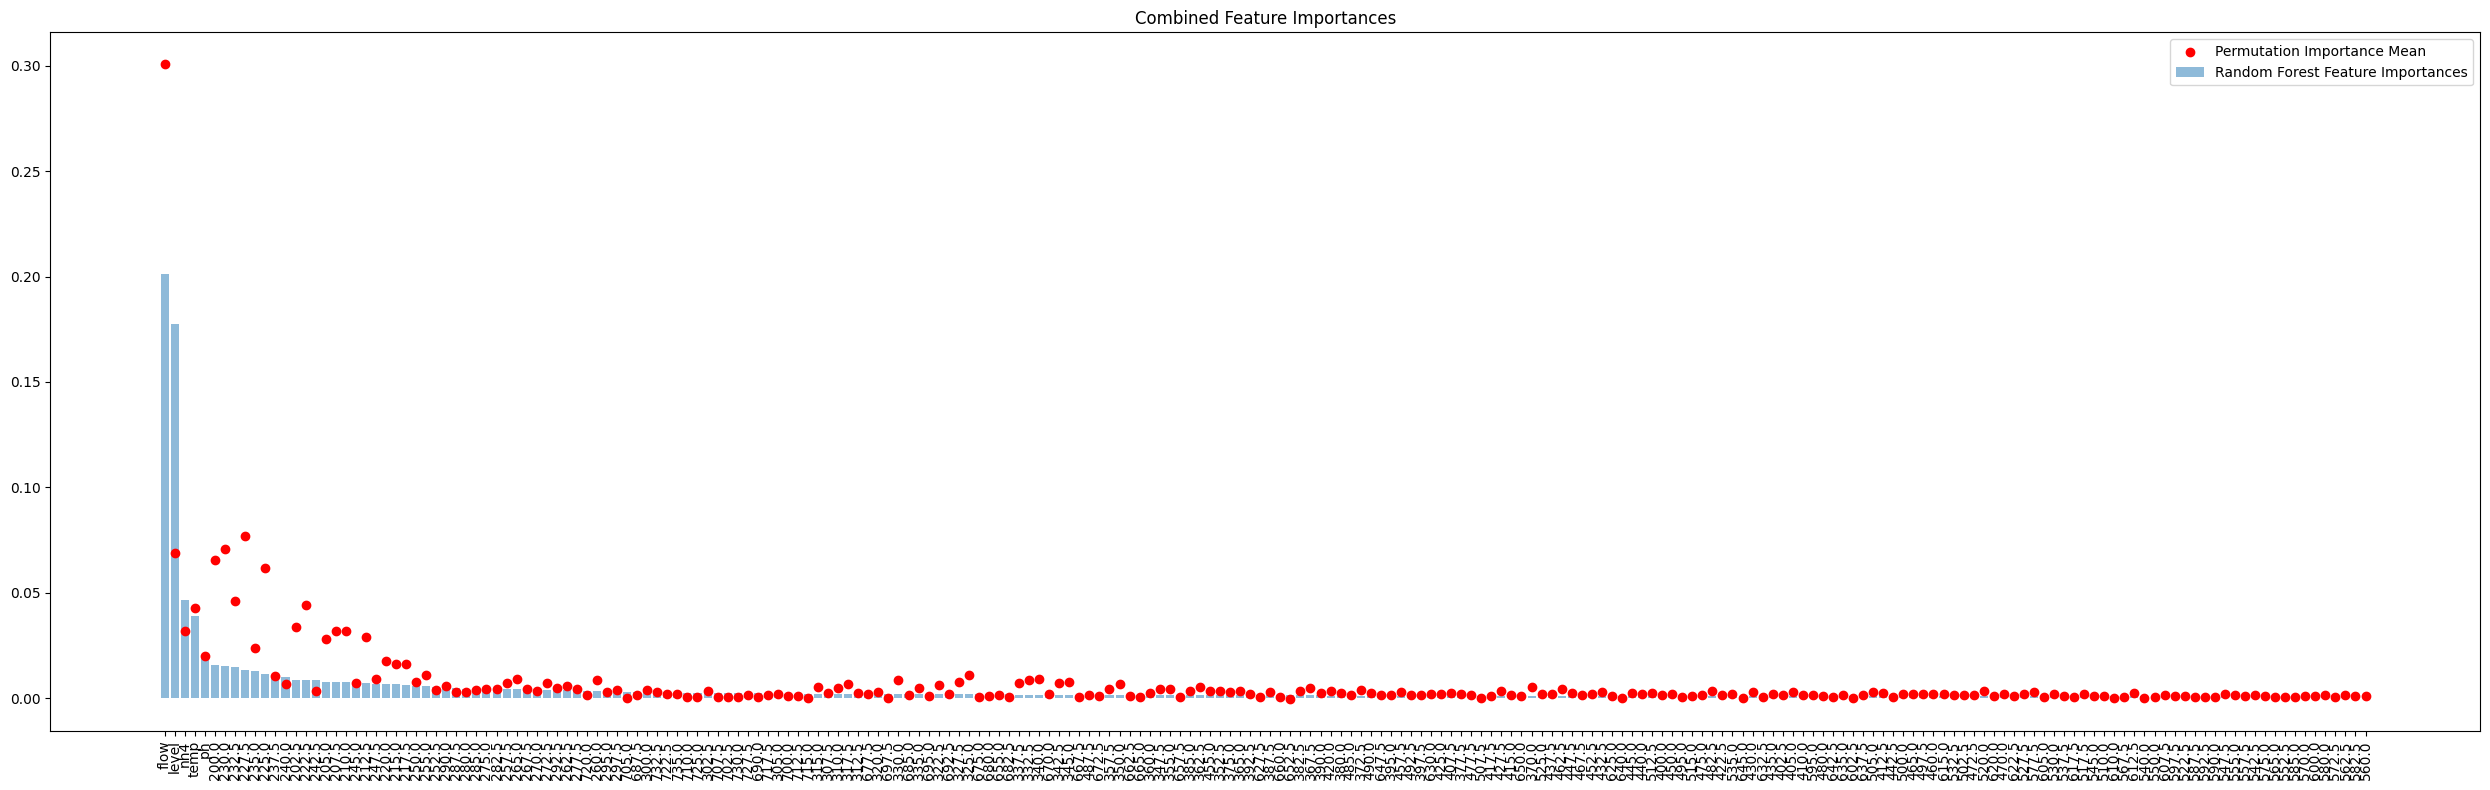

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

# Assuming you have your model trained (rf for RandomForest and model for the model you used in permutation importance)
# and your data ready (X_train, X_test, y_train, y_test)
X = df.drop(['rain'], axis=1)
y = df['rain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Feature importances from Random Forest
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

# Permutation importances
def keras_f1(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return f1_score(y_true, (y_pred > 0.2).astype(int))

perm_importance_result = permutation_importance(history_all.model, X_test, y_test, scoring=keras_f1, n_repeats=30, random_state=42)
perm_importances_mean = perm_importance_result.importances_mean

# Combined plot
plt.figure(figsize=(25, 8))

# Random Forest importances
rf_bar = plt.bar(np.arange(len(rf_importances)), rf_importances[rf_indices], alpha=0.5, label='Random Forest Feature Importances')

# Permutation importances
perm_scatter = plt.scatter(np.arange(len(perm_importances_mean)), perm_importances_mean[rf_indices], color='red', label='Permutation Importance Mean')

plt.title("Combined Feature Importances")
plt.xticks(np.arange(len(rf_importances)), X_train.columns[rf_indices], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## Reflectance Vs Absorbance Spectras to predict rainfall(Using RandomForest)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def rename_columns(df, prefix):
    """
    Renames the columns of a DataFrame with a specified prefix, excluding 'timestamp' and 'rain'.
    """
    columns = {col: f"{prefix}_{col}" for col in df.columns if col not in ['timestamp', 'rain']}
    df.rename(columns=columns, inplace=True)
    return df

def prepare_data(df,label):
    """
    Encodes the target variable and scales the features of the DataFrame.
    """
    X = df.drop([label], axis=1)
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

def train_random_forest(X_train, y_train):
    """
    Trains a RandomForestClassifier using GridSearchCV with cross-validation.
    """
    clf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 100, 150,300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score)
    }
    grid_clf = GridSearchCV(clf, param_grid, scoring=scorers, refit='precision_score', cv=3, verbose=2, n_jobs=-1)
    grid_clf.fit(X_train, y_train)

    return grid_clf

def evaluate_model(grid_clf, X_test, y_test):
    """
    Evaluates the performance of the trained model using test data.
    """
    accuracy = grid_clf.score(X_test, y_test)
    best_params = grid_clf.best_params_
    results = grid_clf.cv_results_
    best_precision = results['mean_test_precision_score'][grid_clf.best_index_]
    best_recall = results['mean_test_recall_score'][grid_clf.best_index_]

    print(f"Best parameters for precision: {best_params}")
    print(f"Best precision: {best_precision}")
    print(f"Best recall: {best_recall}")
    print(f"Test Accuracy: {accuracy}")

# Load your mergedAS_df and mergedRS_df here, then proceed with renaming and merging
mergedAS_df = rename_columns(mergedAS_df, 'AS')
mergedRS_df = rename_columns(mergedRS_df, 'RS')

# Choose which dataframe to use for modeling (e.g., mergedRS_df or mergedAS_df)
chosen_df = mergedRS_df.copy()  # or mergedAS_df
label = 'rain'
X_train, X_test, y_train, y_test, label_encoder, scaler = prepare_data(chosen_df, label)

# Train the model and evaluate
grid_clf = train_random_forest(X_train, y_train)
evaluate_model(grid_clf, X_test, y_test)
